In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import skeleton_methods.skeleton as skel
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
from scipy.stats import gaussian_kde
import collections
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score
from scipy.spatial import distance_matrix
import igraph

import random
 
random.seed(123)

adataTop = scv.read('data/pancreasTop5000.h5ad')
adata = scv.read('data/pancreas.h5ad')

import pickle
layout_r = pickle.load(open("layout_r.pkl","rb"))[0]
skeleton_r = pickle.load(open("skeleton_r.pkl","rb"))

In [16]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
adataTop2000 = adata[:,top_genes[:2000]]

In [17]:
velocity = adataTop2000.layers["velocity"]

In [18]:
knots = skeleton_r["centers"]
voron_weights = skeleton_r["voron_weights"]

from collections import defaultdict
idxSet = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    idxSet[i] = skeleton_r["cluster"] == i

knot_velocity = np.array([[0.0 for _ in  range(velocity.shape[1])] for _ in range(len(knots))])
for i in range(len(knots)):
    knot_velocity[i,:] = np.mean(velocity[idxSet[i],:], axis = 0)


In [19]:
from numpy.linalg import norm
knot_velocity_graph = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(len(knots)):
        if i != j and voron_weights[i,j] > 0:
            xdiff = (adataTop2000.X[j,:]-  adataTop2000.X[i,:]).toarray()[0]
            knot_velocity_graph[i,j] = np.dot(knot_velocity[i,:], xdiff)/norm(xdiff)

In [20]:
# to reverse the arrows for negative directions
knot_velocity_graph1 = np.array([[0.0 for _ in  range(len(knots))] for _ in range(len(knots))])
for i in range(len(knots)):
    for j in range(len(knots)):
        if knot_velocity_graph[i,j] > 0:
             knot_velocity_graph1[i,j] = knot_velocity_graph[i,j]

In [21]:
np.quantile(abs(knot_velocity_graph[knot_velocity_graph!=0]), [0,0.25,.5,0.75,1])

array([3.23916300e-04, 2.69500888e-01, 5.52490645e-01, 1.13761886e+00,
       1.33953221e+01])

In [22]:
velog_r = igraph.Graph.Weighted_Adjacency(knot_velocity_graph1.tolist(),  mode='directed') 

<Axes: >

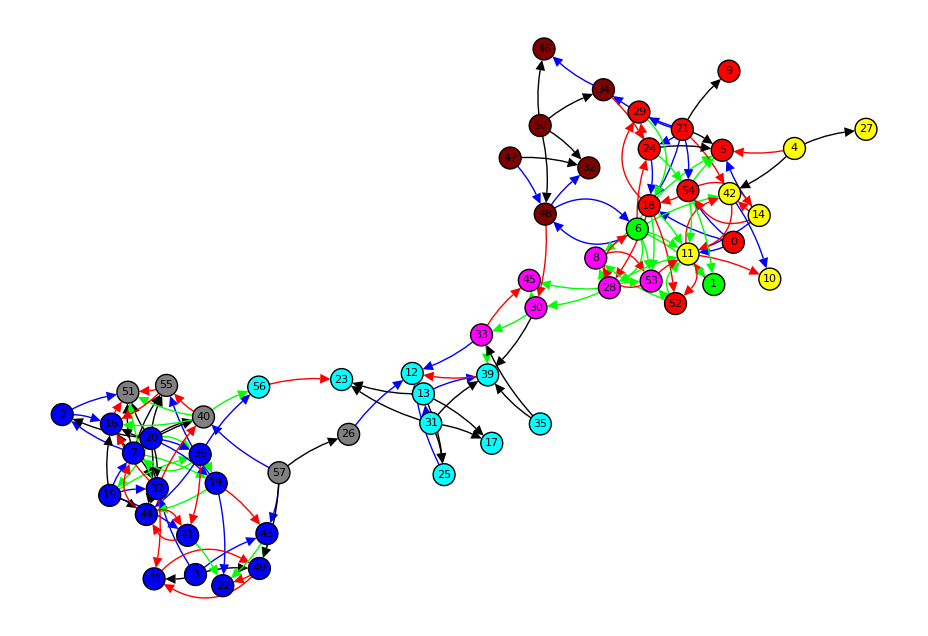

In [23]:
from collections import defaultdict
X_nn = skeleton_r["nn"]
knots = skeleton_r["centers"]

knotClusbyCell = defaultdict(lambda: "Not Present")
for i in range(len(knots)):
    df = pd.Series(adataTop.obs['clusters'][X_nn[:,0] == i])
    knotClusbyCell[i] = df.value_counts()

majorCellClus = [knotClusbyCell[i].index[0] for i in range(len(knots))]

id_gen = igraph.UniqueIdGenerator()
vcolor_indices = [id_gen.add(value) for value in majorCellClus]
palette = igraph.ClusterColoringPalette(len(id_gen))
vcolors = [palette[index] for index in vcolor_indices]
velog_r.vs["color"] = vcolors 

velog_r.vs["label"] = [i for i in range(len(knots))]

bins = np.quantile(np.array(velog_r.es["weight"]), [0,0.25, 0.5, 0.75,1])
bins[0] = bins[0] -1
bins[-1] = bins[-1] +1
edgeWeightCat = pd.cut(pd.Series(velog_r.es["weight"]), bins)
edgeWeightCatcode = edgeWeightCat.cat.codes

palette = list(igraph.ClusterColoringPalette(len(np.unique(edgeWeightCatcode))))
palette[3] = (0.0, 0.0, 0.0, 1.0)
edgecolors = [palette[index] for index in edgeWeightCatcode]
velog_r.es["color"] = edgecolors 

velog_r.es['width'] = edgeWeightCatcode*2 + 1


fig, ax = plt.subplots(figsize=(12,8))
igraph.plot(velog_r, layout=layout_r, target=ax, autocurve = True,edge_curved="0.1", edge_width = 1,vertex_size = 0.2, vertex_label_size = 8)